# Introducing SIREN

In [86]:
# Import libraries
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, 
                             plot_confusion_matrix, classification_report, roc_auc_score, roc_curve,plot_roc_curve, ConfusionMatrixDisplay)

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier, VotingClassifier, BaggingClassifier)

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance

# Import custom module
import SIREN_func

In [24]:
 # Ensuring the notebook remains tidy
import warnings
warnings.filterwarnings('ignore')

In [2]:
full = pd.read_pickle('../data/full.pkl')

In [3]:
# Preview dataset
SIREN_func.eda_clean(full)

Dataset Statistics:
Shape of dataframe: (823, 285)
% of Null values in dataframe: 0.0%
% duplicate rows: 0.0%

Column names: Index(['eri', 'eri_1m_chg', 'eri_3m_chg', 'cesiusd_1w_chg', 'cesieur_1w_chg',
       'cesigbp_1w_chg', 'cesijpy_1w_chg', 'cesicny_1w_chg', 'cesiglf_1w_chg',
       'cesiusd_4w_chg',
       ...
       'skew', 'aaii_bull', 'aaii_bear', 'aaii_neut', 'cftc_nc_net',
       'cftc_nc_long', 'cftc_nc_short', 'cftc_oi', 'cftc_nc_net_pct_oi',
       'cboe_us'],
      dtype='object', length=285)
Columns Count: 
float64    285
dtype: int64


In [9]:
X = full.copy().drop(columns=['spx', 'sx5e', 'ftse100', 'tpx', 'msci_axj', 'msci_acw']).reset_index()
X_train = X.loc[X['date'] < '2015'].drop(columns='date')
X_validate = X.loc[(X['date'] >= '2015') & (X['date'] < '2019')].drop(columns='date')
X_test = X.loc[(X['date'] >= '2019') & (X['date'] != '2020')].drop(columns='date')

In [96]:
y = full['spx'].copy().apply(lambda x: 1 if x < 2.5 else 0).reset_index()
y_train = y.loc[y['date'] < '2015'].drop(columns='date')
y_validate = y.loc[(y['date'] >= '2015') & (y['date'] < '2019')].drop(columns='date')
y_test = y.loc[(y['date'] >= '2019') & (y['date'] != '2020')].drop(columns='date')

In [97]:
# Set-up pipeline for CVEC
pipe_logr = Pipeline([
    ('ss', StandardScaler()),
    ('logr', LogisticRegression())
])

In [98]:
def run_model(mod, mod_params={}, grid_search=False):
    # Initialise dictionary to store model results
    results = {}

    # Create pipeline
    pipe = Pipeline([
        ('ss', StandardScaler()),
        (mod, models[mod])
        ])

    if grid_search:
        # Create list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=5, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs

    else:
        pipe.fit(X_train, y_train)

    # Retrieve metrics
    val_predictions = pipe.predict(X_validate)
    test_predictions = pipe.predict(X_test)
    y_validate_pred_prob = pipe.predict_proba(X_validate)[:,1]
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]

    results['model'] = mod
    results['val_accuracy'] = accuracy_score(y_validate, val_predictions)
    results['val_f1'] = f1_score(y_validate, val_predictions)
    results['val_recall'] = recall_score(y_validate, val_predictions)
    results['val_precision'] = precision_score(y_validate, val_predictions)
    results['val_auc'] = roc_auc_score(y_validate, y_validate_pred_prob)

    results['test_accuracy'] = accuracy_score(y_test, test_predictions)
    results['test_f1'] = f1_score(y_test, test_predictions)
    results['test_recall'] = recall_score(y_test, test_predictions)
    results['test_precision'] = precision_score(y_test, test_predictions)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)

    if grid_search == True:
        gs_list.append(results)
        print(f'Best parameters are:')
        display(pipe.best_params_)

    else: init_list.append(results)

    return pipe


In [100]:
%%time

X_train_copy = X_train.astype(float).copy()
y_train_copy = y_train.astype(float).copy()
  
    
# Instiantiate models
models = {
    'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'), 
    'rf': RandomForestClassifier(random_state=42),
    'gb': GradientBoostingClassifier(random_state=42),
    'dt': DecisionTreeClassifier(random_state=42),
    'et': ExtraTreesClassifier(random_state=42),
    'ada': AdaBoostClassifier(random_state=42),
    'svc': SVC(random_state=42, probability=True),
    'xgb': XGBClassifier(random_state=42, eval_metric='mlogloss', verbosity=1, n_jobs=-1)}

    # Instantiate lists to store results
init_list = []
gs_list = []

for m in models:
    run_model(m)

result_df = pd.DataFrame(init_list).sort_values(by=["val_accuracy"], ascending=False).reset_index(drop=True)
display(result_df)

X_train = X_train_copy
y_train = y_train_copy

,model,val_accuracy,val_f1,val_recall,val_precision,val_auc,test_accuracy,test_f1,test_recall,test_precision,test_auc
0,et,0.789474,0.879781,0.975758,0.800995,0.607782,0.560510,0.698690,0.963855,0.547945,0.684223
1,rf,0.770335,0.868132,0.957576,0.793970,0.579959,0.535032,0.681223,0.939759,0.534247,0.645067
2,svc,0.770335,0.866667,0.945455,0.800000,0.623003,0.560510,0.706383,1.000000,0.546053,0.711495
3,xgb,0.727273,0.835735,0.878788,0.796703,0.493388,0.592357,0.706422,0.927711,0.570370,0.626343
4,gb,0.650718,0.776758,0.769697,0.783951,0.489532,0.515924,0.644860,0.831325,0.526718,0.553077
5,ada,0.622010,0.749206,0.715152,0.786667,0.450138,0.547771,0.616216,0.686747,0.558824,0.533214
6,dt,0.559809,0.689189,0.618182,0.778626,0.479545,0.503185,0.524390,0.518072,0.530864,0.502279
7,lr,0.521531,0.640288,0.539394,0.787611,0.516942,0.617834,0.642857,0.650602,0.635294,0.675838


Wall time: 9.93 s


## Appendix

In [61]:
# Set up parameters specific to CVEC and logistic regression
logr_cvec_params = {
    'logr__max_iter': [100, 200]
}

In [62]:
# Initialize GridSearchCV
gs_logr = GridSearchCV(pipe_logr, param_grid = logr_cvec_params, cv=5, verbose=1)

In [63]:
gs_logr.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('logr', LogisticRegression())]),
             param_grid={'logr__max_iter': [100, 200]}, verbose=1)

0.9168490153172867


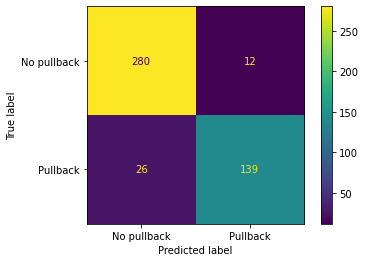

In [64]:
# Generating predictions for our test data
gs_logr_preds = gs_logr.best_estimator_.predict(X_train)

# Creating a confusion matrix
gs_logr_cm = confusion_matrix(y_train, gs_logr_preds)
print(gs_logr.best_estimator_.score(X_train, y_train))
ConfusionMatrixDisplay(confusion_matrix = gs_logr_cm, display_labels=['No pullback', 'Pullback']).plot();

0.45454545454545453


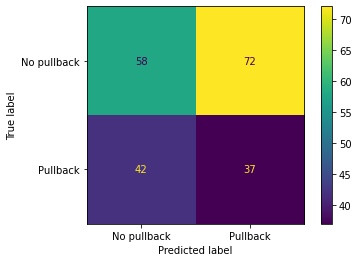

In [65]:
# Generating predictions for our test data
gs_logr_preds = gs_logr.best_estimator_.predict(X_validate)

# Creating a confusion matrix
gs_logr_cm = confusion_matrix(y_validate, gs_logr_preds)
print(gs_logr.best_estimator_.score(X_validate, y_validate))
ConfusionMatrixDisplay(confusion_matrix = gs_logr_cm, display_labels=['No pullback', 'Pullback']).plot();

0.5923566878980892


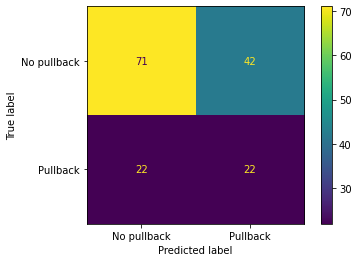

In [66]:
# Generating predictions for our test data
gs_logr_preds = gs_logr.best_estimator_.predict(X_test)

# Creating a confusion matrix
gs_logr_cm = confusion_matrix(y_test, gs_logr_preds)
print(gs_logr.best_estimator_.score(X_test, y_test))
ConfusionMatrixDisplay(confusion_matrix = gs_logr_cm, display_labels=['No pullback', 'Pullback']).plot();